In [74]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras import layers, Model
import importlib
import cifar10_utils 
importlib.reload(cifar10_utils)
from cifar10_utils import *

# ---- GPU setup (safe defaults) ----
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter logs

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.set_visible_devices(gpus[0], 'GPU')  # pick first GPU
        print("[INFO] Using GPU:", tf.config.get_visible_devices('GPU'))
    except Exception as e:
        print("[WARN] Could not set memory growth/visibility:", e)
else:
    print("[WARN] No GPU detected—running on CPU")

# ---------------- Config ----------------
EPS = 8 / 255.0
ALPHA = 2 / 255.0
EPS_EVAL = 8 / 255.0
PGD_STEPS_TRAIN = 10          # training attack steps
PGD_STEPS_EVAL = 20     # eval attack steps




[INFO] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[INFO] Using GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [75]:
# Load CIFAR-10
X_train, y_train_f, X_test, y_test_f, train_ds, test_ds, test_labels = load_cifar10()

In [76]:

# Define mapping

# ------------- Mapping  -------------
#T1 = [[0,1,8,9], [3,4,5,7], [2,6]] #T1(vehicles/mammals/other)
#T2 = [[0,8], [1,9], [2,3,4,5,6,7]] #T2 (ship and airplane/truck and car/all animalls)
#T3 = [[0,8], [1,9], [3,4,5,7], [2,6]] #T3 ship and airplane/truck and car/mammals/other

# Random grouping into 3 clusters
T4 = [[0, 3, 6], [1, 4, 8], [2, 5, 7, 9]] #T4 Random
#T5 = [[0, 5], [1, 7, 9], [2, 8], [3, 4, 6]] #T5 Random

Mapping_T = T4
A_np, A_tf, coarse_test_labels = build_mapping(Mapping_T, test_labels)


In [77]:
# ---- saved models path ----
NT_PATH  = "./CIFAR10_models/CIFAR10_NT64ep_final.keras"
SAT_PATH = "./CIFAR10_models/CIFAR10_VGG16LIKE_SAT_PGD10_eps8.keras"  
CAT_PATH = "./CIFAR10_models/CIFAR10_VGG16LIKE_CAT_PGD10_eps8_T4_final.keras"  

# ---- load models ----
model_nt  = load_model(NT_PATH,  compile=False)
model_sat = load_model(SAT_PATH, compile=False)
model_cat = load_model(CAT_PATH, compile=False)
print("[NT] CASR(ε=8/255):",  eval_casr(model_nt, test_ds, test_labels, Mapping_T, eps=EPS_EVAL, alpha=ALPHA, steps=PGD_STEPS_EVAL))
print("[SAT] CASR(ε=8/255):",  eval_casr(model_sat, test_ds, test_labels, Mapping_T, eps=EPS_EVAL, alpha=ALPHA, steps=PGD_STEPS_EVAL))
print("[CAT] CASR(ε=8/255):",  eval_casr(model_cat, test_ds, test_labels, Mapping_T, eps=EPS_EVAL, alpha=ALPHA, steps=PGD_STEPS_EVAL))

[NT] CASR(ε=8/255): 0.8669
[SAT] CASR(ε=8/255): 0.5989
[CAT] CASR(ε=8/255): 0.5298


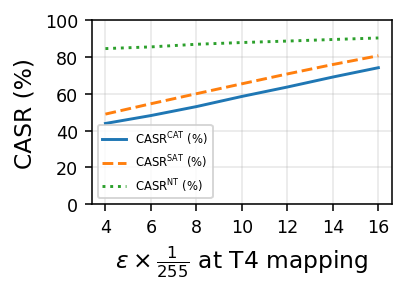

In [72]:
# ===============================
# CASR-vs-epsilon curves for NT / SAT / CAT
# ===============================
import matplotlib.pyplot as plt
# ---- saved models path ----
NT_PATH  = "./CIFAR10_models/CIFAR10_NT64ep_final.keras"
SAT_PATH = "./CIFAR10_models/CIFAR10_VGG16LIKE_SAT_PGD10_eps8.keras"  
CAT_PATH = "./CIFAR10_models/CIFAR10_VGG16LIKE_CAT_PGD10_eps8_T4_final.keras"  

# ---- load models ----
model_nt  = load_model(NT_PATH,  compile=False)
model_sat = load_model(SAT_PATH, compile=False)
model_cat = load_model(CAT_PATH, compile=False)
# ---- epsilon grid ----
# epsilon grid in l_inf (normalized to [0,1])
EPS_GRID = (np.array([4,6,8,10,12,14,16], dtype=np.float32) / 255.0)
# choose a step-size schedule for PGD-20
def step_size_for(eps):

    return max(1.0/255.0, float(eps)/4.0)

def casr_curve(model, eps_values, mapping_T, steps=20):
    ys = []
    for eps in eps_values:
        alpha = step_size_for(eps)
        # We reuse your evaluate(); only CASR is needed here
        casr = eval_casr(model, test_ds, test_labels, mapping_T, eps=eps, alpha=alpha, steps=steps)
        ys.append(100.0 * casr)  # percentage
    return np.array(ys, dtype=np.float32)

# ---- load models ----
model_nt  = load_model(NT_PATH,  compile=False)
model_sat = load_model(SAT_PATH, compile=False)
model_cat = load_model(CAT_PATH, compile=False)

# ---- compute curves ----
y_nt  = casr_curve(model_nt,  EPS_GRID, Mapping_T, steps=PGD_STEPS_EVAL)
y_sat = casr_curve(model_sat, EPS_GRID, Mapping_T, steps=PGD_STEPS_EVAL)
y_cat = casr_curve(model_cat, EPS_GRID, Mapping_T, steps=PGD_STEPS_EVAL)
# ---- pretty tick labels like "8/255" ----
tick_labels = [f"{int(e*255)}" for e in EPS_GRID]
# ---- pretty label for mapping ----
def mapping_text(mapping_T):
    parts = []
    for grp in mapping_T:
        parts.append("{" + ",".join(map(str, grp)) + "}")
    return ", ".join(parts)

mc = len(Mapping_T)


# ---- plot ----
plt.figure(figsize=(3.0,2.2) ,dpi=140)
plt.rcParams.update({
    "font.size": 10,
    "axes.labelsize": 12,
    "legend.fontsize": 6,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
})
plt.plot(EPS_GRID, y_cat, label=fr"CASR$^{{\mathrm{{CAT}}}}$ (%)")
plt.plot(EPS_GRID, y_sat, linestyle="--", label=fr"CASR$^{{\mathrm{{SAT}}}}$ (%)")
plt.plot(EPS_GRID, y_nt,  linestyle=":",  label=fr"CASR$^{{\mathrm{{NT}}}}$ (%) ")
plt.xlabel(r"$\epsilon \times \frac{1}{255}$ at T4 mapping")
plt.ylabel("CASR (%)")
plt.xticks(EPS_GRID, tick_labels)
plt.ylim ([0, 100])
plt.grid(True, alpha=0.3)
plt.legend(loc="best", frameon=True)
plt.tight_layout()
plt.show()
